# Data analysis

Import important libraries

In [1]:
import collections, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import operator

First, we create a list where all functions are stored.


In [2]:
# use os.path since we're using MacOS and Widows and paths are written differently
genesis_file = os.path.join('data\phrase_functions', 'phrase_functions_Genesis.txt') #CODY
genesis_file = 'phrase_functions_Genesis.txt' #ETIENNE

bookFunctions = []
with open(genesis_file) as inputfile:
    for line in inputfile:
        bookFunctions.append(line.strip().split(' '))
        
bookFunctions[:3] # sample data

[['Conj', 'Pred', 'Subj'],
 ['Conj', 'Pred', 'Subj'],
 ['Conj', 'Pred', 'Subj', 'Objc']]

Now, we can extract the unique function names. This is done in a set because a set does not contain duplicates. Hereafter, we sort these function names and put it in a list for a pandas df.

In [3]:
setFunctions = set()
for item in bookFunctions:
    for abstract in item:
        setFunctions.add(abstract)

uniqueFunctions = sorted(list(setFunctions))

uniqueFunctions[0:5] # sample

['Adju', 'Cmpl', 'Conj', 'Loca', 'Modi']

To create a pandas dataframe, we need to know in which clause which function name occurs. Therefore, each row represents a clause and a number in a column represents the occurence of a function in a clause.

In [4]:
zeromatrix= np.zeros((len(bookFunctions), len(uniqueFunctions)))

for row, functions in enumerate(bookFunctions):
    for functionName in functions:
        column = uniqueFunctions.index(functionName) # clever
        zeromatrix[row][column]+=1
        
df = pd.DataFrame(zeromatrix, columns = uniqueFunctions)
df.index.name = "Clause"

df.head(2) # sample

,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time
Clause,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


If you want to see the datafile, type df in the above cell.

# Frequency of functions in the clauses

Here, I look at the top 10 most frequent functions in the clauses

In [5]:
frequencyFunction = df.sum(0).to_dict()

                                 # operator cleaner than lambda! I like it!
sorted(frequencyFunction.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('Pred', 2630.0),
 ('Conj', 2548.0),
 ('Subj', 1349.0),
 ('Cmpl', 1219.0),
 ('Objc', 905.0),
 ('PreC', 453.0),
 ('Rela', 195.0),
 ('Time', 169.0),
 ('Adju', 166.0),
 ('Loca', 118.0)]

Since we got absolute frequency (which is just counting the amount that a function occurs in the clauses), we can calculate the relative frequency of functions. This means that we just divide the total number of occurences by the total number of clauses. 

In [6]:
relativeFrequency = frequencyFunction
for key, value in frequencyFunction.items():
    relativeFrequency[key] = value / len(df)
sorted(relativeFrequency.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('Pred', 0.81677018633540377),
 ('Conj', 0.79130434782608694),
 ('Subj', 0.418944099378882),
 ('Cmpl', 0.37857142857142856),
 ('Objc', 0.28105590062111802),
 ('PreC', 0.1406832298136646),
 ('Rela', 0.060559006211180127),
 ('Time', 0.052484472049689444),
 ('Adju', 0.051552795031055899),
 ('Loca', 0.036645962732919257)]

Note that the use of an explicit subject is in less than half of all clauses here. Typically in Hebrew narrative an explicit subject is used to either change or focus on a given subject. Otherwise, the subject is contained within the verb form itself (i.e., `Pred`). 

Note also that it is possible (in 19% of the cases here) to have a clause without a verb (`Pred`). These kinds of clauses typically have a larger share of the total in other genres, especially poetry and prophecy. For instance, in the Song of Songs (Hooglied), the verbless clause accounts for as much as 36% of all clauses ([see here](https://github.com/codykingham/SongofSongs-Syntax/blob/master/Clause_Syntax/clause_stats.ipynb)).

Now that we have looked at the number of occurences of function names, we can also look at how many functions are given in each clause on average.

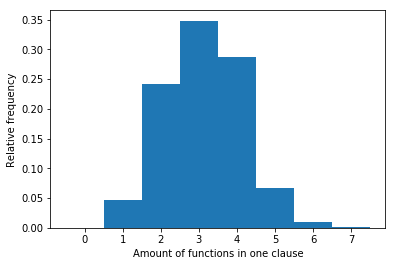

In [7]:
amountFunctions = np.asarray(df.sum(1)) # 1 here stands for row? Etienne: YES! It's the sum over the rows
plt.hist(amountFunctions,bins=np.arange(9)-0.5, normed=True) # normed gives ratio? fantastic.
plt.xlabel('Amount of functions in one clause')
plt.ylabel('Relative frequency')
plt.show()

In [8]:
counter = collections.Counter(amountFunctions)
print(counter)

Counter({3.0: 1121, 4.0: 922, 2.0: 777, 5.0: 213, 1.0: 149, 6.0: 32, 7.0: 6})


Now, we can compute some statistics over the number of functions given in one clause

In [9]:
print("Mean: "+str(np.mean(amountFunctions))+", Variance: "+str(np.var(amountFunctions)))


Mean: 3.12204968944, Variance: 1.08168772424


# Pattern Recognition


Next step is finding patterns in the clauses. There are a lot of clauses which have the same functions in it. Therefore, we want to know how often some combination of functions (not looking at the order, only if it occurs or not) occurs in the data.


In [10]:
# love these df functions -Cody
dfCount = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})
dfCount[:10]

,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,84
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,19
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,9


As you can see in the data above, the number counts indicates the frequency some combination of functions occurs. Of course we can sort this and print the top 20

In [11]:
dfCount.sort_values(["count"], ascending=False)[:10]

,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,count
53,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,415
156,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,300
158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,280
55,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,248
72,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,191
74,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,137
169,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,131
64,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,94
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,84
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65


Again we can make this relative

In [12]:
dfCount['count'] = dfCount['count']/len(df)
dfCount.sort_values(["count"], ascending=False)[:10]

,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,count
53,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.128882
156,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.093168
158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.086957
55,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.077019
72,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.059317
74,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.042547
169,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.040683
64,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.029193
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.026087
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.020186


# Probability That a Function is Followed by Another


First, we count the frequency that a word is followed by another. This means that for a clause containing "FunctionA, FunctionB, FunctionC," we say that FunctionA --> FunctionB is one occurence of going from A to B. Then, we do the same for Function B -> Function C. A Clause always needs to start, so Clause-end indicates we go from nothing to the first function or when the clause ends with a function we say we end the clause.

In [13]:
transitionMatrix = np.zeros((len(uniqueFunctions)+1,len(uniqueFunctions)+1))
transitionNodes = ["CLAUSE-END"] + uniqueFunctions 

# count transitions using bigrams
for clause in bookFunctions:
    transitionMatrix[0][transitionNodes.index(clause[0])]+=1
    for i in range(0,len(clause)-1):
        transitionMatrix[transitionNodes.index(clause[i])][transitionNodes.index(clause[i+1])]+=1        
    transitionMatrix[transitionNodes.index(clause[-1])][0]+=1 # clause-end
    
dfTransition = pd.DataFrame(transitionMatrix, columns = transitionNodes) # convert to dataframe

dfTransition["Index"] = pd.Series(transitionNodes, index=dfTransition.index) # add row labels
dfTransition = dfTransition.set_index("Index")
dfTransition["Sum"]= dfTransition.sum(1) # add sum col
dfTransition

,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Index,,,,,,,,,,,,,,,,
CLAUSE-END,0.0,22.0,12.0,2545.0,0.0,3.0,1.0,13.0,49.0,17.0,58.0,201.0,192.0,99.0,8.0,3220.0
Adju,109.0,12.0,9.0,0.0,1.0,2.0,2.0,3.0,3.0,0.0,0.0,17.0,0.0,4.0,4.0,166.0
Cmpl,891.0,28.0,36.0,0.0,25.0,17.0,2.0,80.0,4.0,0.0,0.0,23.0,0.0,98.0,15.0,1219.0
Conj,0.0,4.0,17.0,3.0,6.0,5.0,33.0,49.0,32.0,77.0,3.0,2121.0,3.0,186.0,9.0,2548.0
Loca,82.0,1.0,3.0,0.0,7.0,0.0,0.0,8.0,1.0,1.0,0.0,4.0,0.0,6.0,5.0,118.0
Modi,53.0,0.0,5.0,0.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,6.0,0.0,3.0,4.0,83.0
Nega,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,39.0,0.0,0.0,0.0,48.0
Objc,573.0,35.0,149.0,0.0,23.0,0.0,4.0,58.0,0.0,0.0,0.0,28.0,0.0,26.0,9.0,905.0
PreC,313.0,13.0,50.0,0.0,8.0,2.0,0.0,14.0,0.0,0.0,0.0,5.0,0.0,39.0,9.0,453.0


 The sum above indicates the total sum over the rows. If we divide each row by the total sum, we have the probabilities we go from one function to the next one.

In [14]:
dfTransitionRelative = dfTransition.loc[:,"CLAUSE-END":"Time"].div(dfTransition["Sum"], axis=0)
dfTransitionRelative["Sum"]= dfTransitionRelative.sum(1)
dfTransitionRelativeRound = dfTransitionRelative.round(3)
dfTransitionRelativeRound

,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Index,,,,,,,,,,,,,,,,
CLAUSE-END,0.000,0.007,0.004,0.790,0.000,0.001,0.000,0.004,0.015,0.005,0.018,0.062,0.060,0.031,0.002,1.0
Adju,0.657,0.072,0.054,0.000,0.006,0.012,0.012,0.018,0.018,0.000,0.000,0.102,0.000,0.024,0.024,1.0
Cmpl,0.731,0.023,0.030,0.000,0.021,0.014,0.002,0.066,0.003,0.000,0.000,0.019,0.000,0.080,0.012,1.0
Conj,0.000,0.002,0.007,0.001,0.002,0.002,0.013,0.019,0.013,0.030,0.001,0.832,0.001,0.073,0.004,1.0
Loca,0.695,0.008,0.025,0.000,0.059,0.000,0.000,0.068,0.008,0.008,0.000,0.034,0.000,0.051,0.042,1.0
Modi,0.639,0.000,0.060,0.000,0.036,0.036,0.000,0.036,0.036,0.000,0.000,0.072,0.000,0.036,0.048,1.0
Nega,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.146,0.000,0.812,0.000,0.000,0.000,1.0
Objc,0.633,0.039,0.165,0.000,0.025,0.000,0.004,0.064,0.000,0.000,0.000,0.031,0.000,0.029,0.010,1.0
PreC,0.691,0.029,0.110,0.000,0.018,0.004,0.000,0.031,0.000,0.000,0.000,0.011,0.000,0.086,0.020,1.0


Here the tendency of the Hebrew narrative verb to shape its clause environment really shows. That verb form, called the *wayyiqtol* ("vay-yiqtōl"), typically comprises a majority of the verb forms in narration. It does two things to the clause specifically, as confirmed by the data we see here:

1. Inserts a conjunction at the beginning of the clause ("And" or waw), which is inherent to the verb form itself. It is the "W" in the *wayyiqtol*. Note that the conjunction does not occur at clause-end in our sample.
2. Since this conjunction (waw) is inherent to the verb form and also because it connects the clause to the preceding clauses, there can be no intervening subjects between the conjunction and the core of the verb, e.g. W + Subject + core_yiqtol_verb.

The data confirms in Genesis these known tendencies about Biblical Hebrew narrative. The conjunction switches to the predicate in 83% of instances it is used in our sample. 

There are some interesting results. Complement elements (adverbs that give extra or necessary information) tend to occur at clause-end.

`Adju` -> `END` (66%), <br> 
`Cmpl` -> `END` (73%), <br>
`Loca`-> `END` (70%), <br>
`Modi` -> `END` (64%), <br>
`Time` -> `END` (73%).

The tendency for the `Time` function phrase observed in our sample is also discussed in the literature (1, 2).

These are the strong tendencies that we see here. But what about the smaller ratios? It may be that these more "movable" elements become even more important for our investigation into the change of the language through time. That would especially be so if we find that the broader tendencies of the two dated-sources are the same, but the subtle tendencies different.

# Markov Chain

In [29]:
dfProb = dfTransitionRelative.drop("Sum",1)
P = np.matrix(dfProb.as_matrix())

n = 100000
Pn = P**(n)

dfPn = pd.DataFrame(Pn, columns = dfProb.columns.values.tolist())

dfPn["Index"] = dfProb.index.values
dfPn = dfPn.set_index("Index")
dfPn["Sum"] = dfPn.sum(1)
dfPn

,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Index,,,,,,,,,,,,,,,,
CLAUSE-END,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Adju,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Cmpl,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Conj,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Loca,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Modi,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Nega,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
Objc,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0
PreC,0.242598,0.012507,0.091841,0.191969,0.00889,0.006253,0.003616,0.068184,0.034129,0.008212,0.004596,0.198147,0.014691,0.101635,0.012733,1.0


The following plot shows the probabilities of the markov chain in each time step. The code originates from https://martin-thoma.com/python-markov-chain-packages/. I added some of my own code. For each time step, it is given the probability that we are in some time step given that we start from the CLAUSE-END


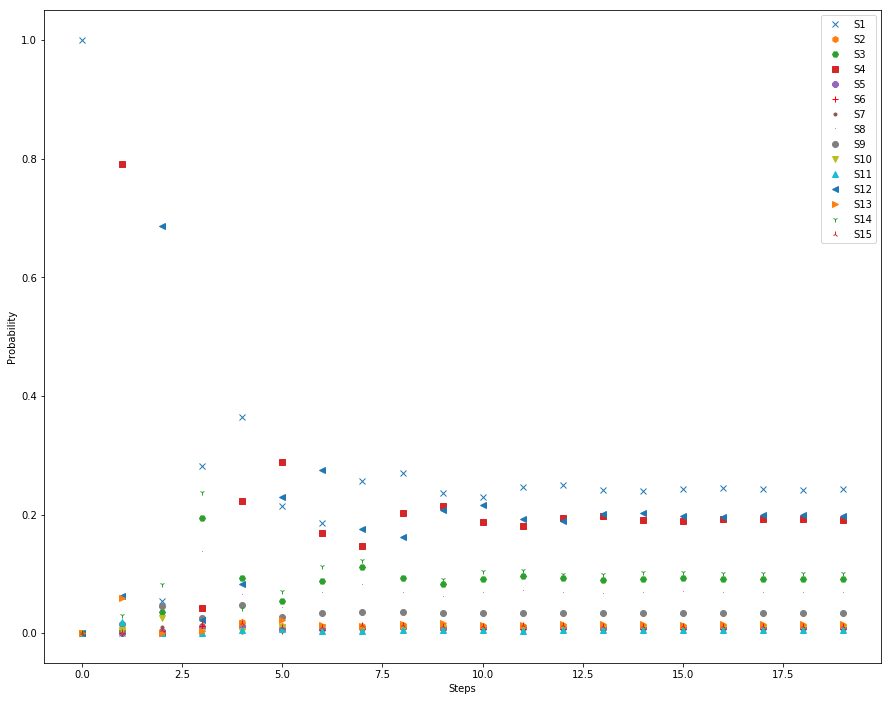

In [38]:
v = np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Get the data
plot_data = []
for step in range(20):
    result = v * P**step
    plot_data.append(np.array(result).flatten())

# Convert the data format
plot_data = np.array(plot_data)

# Create the plot
plt.figure(1, figsize=(15, 12))
plt.xlabel('Steps')
plt.ylabel('Probability')
lines = []
for i, shape in zip(range(15), ['x', 'h', 'H', 's', '8', 'r+', ".", ",", "o", "v", "^", "<", ">", "1","2"]):
    line, = plt.plot(plot_data[:, i], shape, label="S%i" % (i+1))
    lines.append(line)
plt.legend(handles=lines, loc=1)
plt.show()

<hr>

(1) Van der Merwe, C. "'Reference Time' In Some Biblical Temporal Constructions." *Biblica* 78 (1997): 509-511.<br>
(2) Walter Gross, *Die Satzeilfolge im Verbalsatz alttestamentlicher Prosa. Untersucht an den Büchern Dtn, Ri und 2Kön*. Tübingen, 1996. 